<a href="https://colab.research.google.com/github/mamanari/RL1/blob/main/ex2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm

[0.74534382 3.27771681 0.4669624 ]
[-0.32188108 -0.09916507  0.12355094  0.34626694]


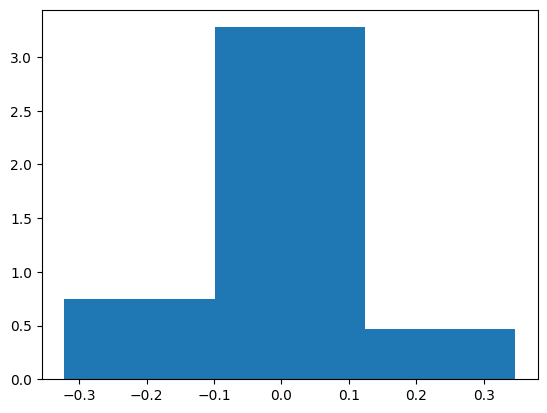

In [21]:
mu = 0.0
sigma = 0.1
normal_distr = np.random.normal(mu, sigma, 1000)

count, bins, ignored = plt.hist(normal_distr, 3, density=True)
print(count)
print(bins)


#plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
#plt.show()

In [22]:
def RandomWalk(q):
    len=np.size(q)
    #choices = [-1, 0, 1]
    #-0.32188108 -0.09916507  0.12355094  0.34626694

    sampl = np.random.uniform(low=-0.32188108, high=0.34626694, size=(len,))
    for i in range(len):
      choise = 0
      if(sampl[i] < -0.09916507):
        choise = -1
      elif(sampl[i] > 0.12355094):
        choise = 1
      q[i]=q[i]+choise

    return q

In [15]:
def epsilon_greedy(q, epsilon, arms):
    '''
    q is a vector holding value estimates for each action a at the timestep
    epsilon is the probability with which the agent doesn't select the greedy action
    arms are the number of actions teh bandit could select
    This function returns the column index to select
    '''

    r = random.uniform(0,1)
    i = np.argmax(q) # find index of highest value action
    column_indexes = list(range(0,arms))

    # Choose a random action (not the max) if we fall into epsilon
    if r <= epsilon:
        column_indexes.remove(i)
        i = random.choice(column_indexes) # choose a random action index
        return i

    # Choose greedily if we don't fall into epsilon
    else:
        return i

In [25]:
def multi_task(epsilon=0.1, max_iter=10000, tasks=500, arms=10, alpha=0.1):
    '''
    epsilon = the probability te agent doesn't selection a greedy action
    max_iter = the number of steps taken by the value function in the random walk
    tasks = the number of random bandits we will average across
    arms = the number of actions a bandit can take at each step
    alpha = the constant stepsize parameter used to calcuate new reward estimates

    This function returns two vectors (constR and variabR) that quanitfy the average reward
    achieved across 500 bandits based on reward estimated via constant/variable stepsizes
    at each timestep
    '''

    rows, cols = tasks, arms

    # create true value of arms with random walk
    q = np.array( [([0]*arms) for i in range(rows)] )
    constQ = np.array( [([0]*cols) for i in range(rows)] )
    variabQ = np.array( [([0]*cols) for i in range(rows)] )
    constN = np.array( [([0]*cols) for i in range(rows)] )
    variabN = np.array( [([0]*cols) for i in range(rows)] )
    constR = np.zeros(max_iter)
    variabR = np.zeros(max_iter)

    # iteration loop (within each iteration we have a random number of bandits (tasks) that we will average over)
    for i in range(max_iter):

        # task loop (the random bandits we cycle through per each iteration)
        for j in range(tasks):
            # random walk of each arm
            # update row j
            task_q = q[j, :]
            task_q = RandomWalk(task_q)
            q[j,:] = task_q

            # CONSTANT STEPSIZE

            # get one random arm from set of tasks
            task_constQ = constQ[j,:]
            task_constN = constN[j,:]

            # find the arm to pick
            action_index_c = epsilon_greedy(task_constQ, epsilon, arms)

            # get reward
            reward_const = q[j, action_index_c]

            # add reward to total rewards for this iteration (to be averaged later)
            constR[i] = constR[i] + reward_const

            # update estimated value of arm based on observation
            task_constQ[action_index_c] = task_constQ[action_index_c] + alpha*(reward_const-task_constQ[action_index_c])
            constQ[j,:] = task_constQ

            # update number of times arm has been selected
            task_constN[action_index_c] = task_constN[action_index_c] + 1
            constN[j:] = task_constN

            # VARYING STEPSIZE

            # get one arm from set of tasks
            task_variabQ = variabQ[j,:]
            task_variabN = variabN[j,:]

            # find arm to pick
            action_index_v = epsilon_greedy(task_variabQ, epsilon, arms)

            # get reward from true values of arms
            reward_variab = q[j,action_index_v]

            # add reward to total rewards for this iteration
            variabR[i] = variabR[i] + reward_variab

            # update number of times arm has been selected
            task_variabN[action_index_v] = task_variabN[action_index_v] + 1
            variabN[j,:] = task_variabN

            # set stepsize to 1 for first iteration
            if i == 0:
                beta = 1
            else:
                beta = (1/task_variabN[action_index_v])

            # update estimated value of action based on observation
            task_variabQ[action_index_v] = task_variabQ[action_index_v] +\
                                           beta*(reward_variab-task_variabQ[action_index_v])
            variabQ[j,:] = task_variabQ

        # get average reward across all bandits for each iteration
        constR[i] = constR[i] / tasks
        variabR[i] = variabR[i] / tasks

    return constR, variabR

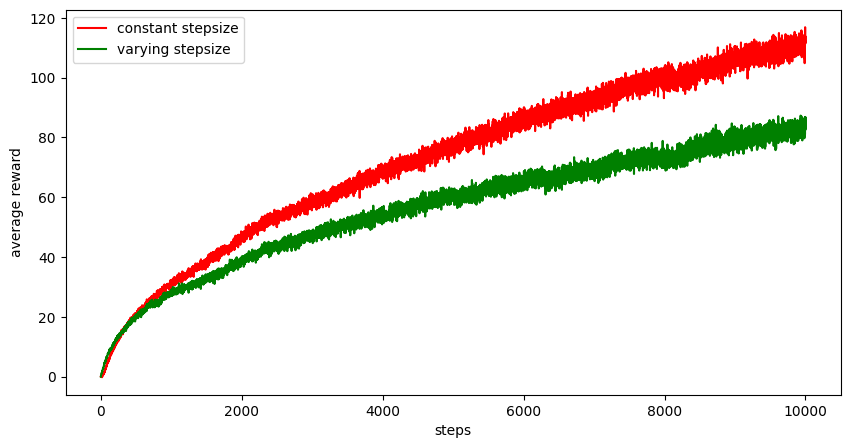

In [26]:
# calculate and plot
R_c_step, R_v_step = multi_task()

fig = plt.figure(figsize=(10,5))
fig.add_subplot(111)
plt.xlabel('steps')
plt.ylabel('average reward')
plt.plot(R_c_step, 'r', label='constant stepsize')
plt.plot(R_v_step, 'g', label='varying stepsize')
plt.legend(loc='upper left')
#plt.savefig('../../notes/images/ex2.5.png', dpi=300)
plt.show()